## Encoding by pronouciation

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import re

In [49]:
import wn
from wn import morphy, validate
ewn = wn.Wordnet('ewn:2020')
m = morphy.Morphy(ewn)

In [28]:
pronouncing_dict_path = './cmudict.dict.txt'

In [29]:
dico = {}
with open(pronouncing_dict_path, 'r', encoding='utf-8') as file:
	for line in file.readlines():
		l = line.strip().split(' ')
		word = l[0]
		pronounciation = ' '.join(l[1:])
		# filter some non standard words
		if word.islower() and word.isalpha():
			dico[word] = pronounciation

In [225]:
len(dico)

117490

first check if the word exists in wordnet

In [62]:
def validate(word):
	# check if exists
	res = wn.synsets(word)
	if res != []:
		return True
	# otherwise check if as a derivation, the lemma exists
	for lemmas_per_pos in m(word).values():
		for lemma in lemmas_per_pos:
			res = wn.synsets(lemma)
			# if there exists one, return
			if res != []:
				return True
	return False

In [64]:
from tqdm import tqdm

In [65]:
non_words = []
for word in tqdm(dico.keys()):
	if not validate(word):
		non_words.append(word)

100%|██████████| 117490/117490 [01:01<00:00, 1897.98it/s]


In [66]:
len(non_words)

65445

In [ ]:
with open('./non_wordnet_words.txt', 'w', encoding='utf-8') as file:
	for non_word in non_words:
		file.write(non_word+'\n')

However, wordnet excludes some function words, they should be taken into account in dictionary

In [37]:
with open('./non_wordnet_words.txt', 'r', encoding='utf-8') as file:
	non_words = file.read().splitlines()

In [31]:
with open('./wordnet_stopwords.txt', 'r', encoding='utf-8') as file:
	stop_words = file.read().splitlines()

In [38]:
for non_word in non_words:
	if not non_word in stop_words:
		dico.pop(non_word)

In [39]:
len(dico)

52123

now we get a well pronounced, wordnet-validated dictionary

In [85]:
df = pd.DataFrame.from_dict(dico, orient='index', columns = ['sound'])

In [86]:
df_freq = pd.read_csv('./dict_en.yaml', sep = '\t', index_col=0, usecols=[1,2])
df_freq

,COUNT
WORD,
in,4501
a,4496
as,4491
it,4486
be,4481
...,...
obsessivity,0
radiolocate,0
pelecypodous,0


In [87]:
df = df.join(df_freq.astype('Int64'))

In [88]:
df.index.name = 'word'

In [89]:
df.rename(columns={'COUNT': 'freq'}, inplace=True)

In [90]:
df

,sound,freq
word,,
a,AH0,4496
aaa,T R IH2 P AH0 L EY1,<NA>
aachen,AA1 K AH0 N,<NA>
aalborg,AO1 L B AO0 R G,<NA>
aalto,AA1 L T OW2,<NA>
...,...,...
zuni,Z UW1 N IY2,<NA>
zurich,Z UH1 R IH0 K,<NA>
zweig,Z W AY1 G,<NA>


In [91]:
def encode(phonemes):
	vowels = re.compile('(AO|UW|EH|AH|AA|IY|IH|UH|AE|AW|AY|ER|EY|OW|OY)\d*', re.VERBOSE)
	phonemes = re.sub(vowels, 'Q', phonemes)
	complex_consonant = re.compile('CH|DH|HH|JH|NG|SH|TH|ZH|')
	# complex consonants
	phonemes = re.sub('HH', 'H', phonemes)
	phonemes = re.sub('CH', 'C', phonemes)
	phonemes = re.sub('JH', 'J', phonemes)
	phonemes = re.sub('TH', 'X', phonemes)
	phonemes = re.sub('DH', 'X', phonemes)
	phonemes = re.sub('SH', 'U', phonemes)
	phonemes = re.sub('ZH', 'O', phonemes)
	phonemes = re.sub('NG', 'I', phonemes)
	
	# remove whitespaces
	phonemes = re.sub(' ', '', phonemes)

	return phonemes

In [92]:
def transcribe(phonemes_list):
	encoding_list = []
	for phonemes in phonemes_list:
		encoding_list.append(encode(phonemes))
	return encoding_list

In [93]:
encoding_list = transcribe(df.sound.astype('str'))
df['encoding'] = encoding_list

In [94]:
df

,sound,freq,encoding
word,,,
a,AH0,4496,Q
aaa,T R IH2 P AH0 L EY1,<NA>,TRQPQLQ
aachen,AA1 K AH0 N,<NA>,QKQN
aalborg,AO1 L B AO0 R G,<NA>,QLBQRG
aalto,AA1 L T OW2,<NA>,QLTQ
...,...,...,...
zuni,Z UW1 N IY2,<NA>,ZQNQ
zurich,Z UH1 R IH0 K,<NA>,ZQRQK
zweig,Z W AY1 G,<NA>,ZWQG


delete non-initial vowels

In [76]:
def remove_vowels(encoding_list):
	res = []
	for encoding in encoding_list:
		if len(encoding) > 1:
			res.append(encoding[0] + re.sub('Q','', encoding[1:-1]) + encoding[-1])
		else:
			res.append(encoding)
	return res

Normalization

We hope that:
1. the plurals and the third person single form are uniformly terminated with S(instead of Z or other possible sound)
2. the past particles are uniformly terminated with E(instead of T or D or other possible sound)
3. the present particles are uniformly terminated with I(this is already done since we encode NG sound by I)

you can take these terminations as a grammatical symbol

In [235]:
df.encoding.loc[(df.index.str.contains('s$', regex=True) == True)]

aardvarks           QRDVQRKS
aarhus                  QHQS
abacus                QBQKQS
abalones            QBQLQNQZ
abandonments    QBQNDQNMQNTS
                    ...     
zones                   ZQNZ
zoologists       ZQWQLQJQSTS
zooms                   ZQMZ
zoos                     ZQZ
zucchinis            ZQKQNQZ
Name: encoding, Length: 13316, dtype: object

In [236]:
df.encoding.loc[(df.index.str.contains('ed$', regex=True) == True)]

abandoned         QBQNDQND
abashed              QBQUT
abated              QBQTQD
abbreviated    QBRQVQYQTQD
abdicated        QBDQKQTQD
                  ...     
zigzagged          ZQGZQGD
zipped                ZQPT
zippered             ZQPQD
zoned                 ZQND
zoomed                ZQMD
Name: encoding, Length: 4701, dtype: object

In [237]:
df.encoding.loc[(df.index.str.contains('ing$', regex=True) == True)]

abandoning        QBQNDQNQI
abating              QBQTQI
abbreviating    QBRQVQYQTQI
abdicating        QBDQKQTQI
abducting          QBDQKTQI
                   ...     
zing                    ZQI
zippering           ZQPQRQI
zipping               ZQPQI
zoning                ZQNQI
zooming               ZQMQI
Name: encoding, Length: 4323, dtype: object

In [107]:
def normalize(encodings: pd.Series):
	plurals_or_third_single_form  = re.compile('s$')
	past_particle = re.compile('ed$')
	present_particle = re.compile('ing$')

	# print(encodings.head())
	# replace voiced plural suffix
	res1 = encodings.loc[(encodings.index.str.contains(plurals_or_third_single_form, regex=True) == True)].str.replace('Z$', 'S', regex=True)
	# print(res1.head())
	# remove -ed, sometimes together with a vowel sound i.
	res2 = encodings.loc[(encodings.index.str.contains(past_particle, regex=True) == True)].str.replace('Q?[T|D]$', 'E', regex = True)
	# print(res2.head())
	# remove -ing, always with a vowel sound i
	res3 = encodings.loc[(encodings.index.str.contains(present_particle, regex=True) == True)].str.replace('Q?I$', 'I', regex = True)
	# print(res3.head())
	
	res = pd.concat([res1, res2, res3])
	return res

In [108]:
res = normalize(df.encoding)

In [109]:
df.loc[['abandons','abandoned','abandoning'], 'encoding']

word
abandons       QBQNDQNZ
abandoned      QBQNDQND
abandoning    QBQNDQNQI
Name: encoding, dtype: object

In [110]:
df.loc[res.index, 'encoding'] = res

In [111]:
df.loc[['abandons','abandoned','abandoning'], 'encoding']

word
abandons      QBQNDQNS
abandoned     QBQNDQNE
abandoning    QBQNDQNI
Name: encoding, dtype: object

Manually correct exceptions

Type letters, 2-grams, 3-grams, 4-grams by themselve  

In [97]:
df.loc[(df.index.str.len() <= 4), 'encoding'] = df.index[(df.index.str.len() <= 4)].str.upper()

In [101]:
df.loc[(df.index.str.len() <= 4) & (df.encoding.str.len() <= 4), ['encoding','freq']]

,encoding,freq
word,,
a,A,4496
aaa,AAA,<NA>
ab,AB,<NA>
aba,ABA,<NA>
abbe,ABBE,<NA>
...,...,...
zoo,ZOO,56
zoom,ZOOM,28
zoos,ZOOS,<NA>


Detect inefficient encoding

In [115]:
df.loc[(df.index.str.len() < df.encoding.str.len()), ['encoding','freq']]

,encoding,freq
word,,
absenteeism,QBSQNTQYQZQM,23
absolutism,QBSQLQTQZQM,16
abuses,QBYQSQS,<NA>
academia,QKQDQMQYQ,33
acadia,QKQDQYQ,<NA>
...,...,...
zodiac,ZQDQYQK,16
zoologist,ZQWQLQJQST,9
zoologists,ZQWQLQJQSTS,<NA>


In [116]:
df['vowel_free'] = remove_vowels(df.encoding) 

In [117]:
df.to_csv('./dict_en.csv')

In [118]:
df = pd.read_csv('./dict_en.csv', index_col=0, dtype={'sound':str,'freq':pd.Int64Dtype(),'encoding':str,'vowel_free':str}, na_filter=False)

In [119]:
df

,sound,freq,encoding,vowel_free
word,,,,
a,AH0,4496,A,A
aaa,T R IH2 P AH0 L EY1,<NA>,AAA,AAA
aachen,AA1 K AH0 N,<NA>,QKQN,QKN
aalborg,AO1 L B AO0 R G,<NA>,QLBQRG,QLBRG
aalto,AA1 L T OW2,<NA>,QLTQ,QLTQ
...,...,...,...,...
zuni,Z UW1 N IY2,<NA>,ZUNI,ZUNI
zurich,Z UH1 R IH0 K,<NA>,ZQRQK,ZRK
zweig,Z W AY1 G,<NA>,ZWQG,ZWG


In [120]:
df.loc['abbreviated']

sound         AH0 B R IY1 V IY0 Y EY2 T IH0 D
freq                                       50
encoding                           QBRQVQYQTE
vowel_free                            QBRVYTE
Name: abbreviated, dtype: object

## Encoding Statistics

encoding length

In [320]:
def plot_string_length_freq(encodings: pd.DataFrame):
	wd_length = encodings.reset_index().apply(lambda x: x.str.len(), axis=0).astype(pd.Int64Dtype())
	display(wd_length.describe(percentiles=[.9,.95,.99]).drop(['count','50%','min']))

	wd_length_count = wd_length.melt()
	wd_length_count = wd_length_count.pivot_table(index='value', columns='variable', values='value', aggfunc='size')
	plt.style.use('seaborn-v0_8-notebook')
	wd_length_count.plot(kind='bar')
	

- less average encoding length: lazier
- less standard deviation of encoding length: evener

,word,encoding,vowel_free
mean,7.912553,6.810583,4.791397
std,2.467701,2.382043,1.459695
90%,11.0,10.0,7.0
95%,12.0,11.0,7.0
99%,14.0,13.0,9.0
max,20.0,19.0,13.0


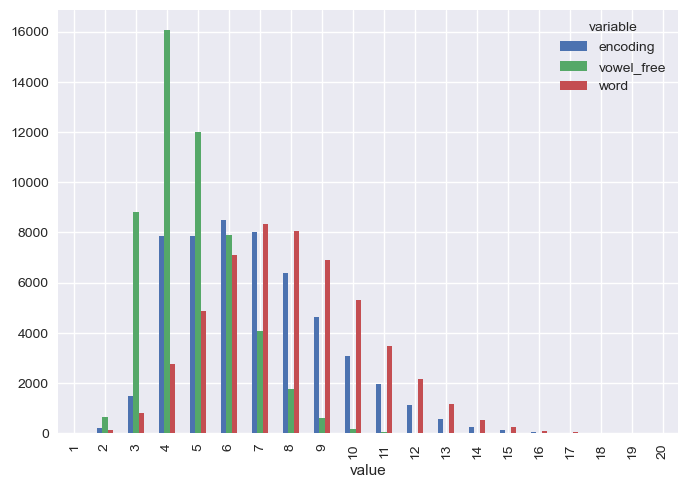

In [322]:
plot_string_length_freq(df[['encoding', 'vowel_free']])

coincident codes: counts of words with same encoding

In [340]:
def coincident_stats(encodings: pd.DataFrame, ext = 10):
	total = len(encodings)

	multiplicity = encodings.value_counts()
	multiplicity.index.name = 'encoding'
	multiplicity.name = 'multiplicity'

	multiplicity_freq = multiplicity.value_counts()
	multiplicity_freq.index.name = 'multiplicity'
	multiplicity_freq.name = 'freq'

	coincident_rate = 1 - (multiplicity_freq.loc[1]) / multiplicity_freq.sum()

	extremes = multiplicity_freq.loc[ext+1:]
	word_count_with_extreme_encodings = (extremes.index.to_numpy() * extremes.values).sum()
	ratio_with_extreme_encodings = np.round( word_count_with_extreme_encodings/total *100 , 2)

	print(f'coincident_rate: {np.round(coincident_rate * 100,2)}%')
	print(f'There are {extremes.sum()} encodings have more than {ext} multiplicities, encoding {word_count_with_extreme_encodings}({ratio_with_extreme_encodings}%) words.')

	q = multiplicity.quantile([.8,.9,.95,.99])
	q.index.name = 'quantile'
	q.name = 'multiplicity'

	print('extreme:')
	display(extremes.to_frame())
	print('quantile:')
	display(q.to_frame())

	extreme_encoding = multiplicity[multiplicity > ext].index.to_series()
	extreme_encoding.name = 'freq'
	extreme_encoding.index.name = 'encoding_length'
	if len(extreme_encoding) > 0:
		# display(extreme_encoding)
		sn.barplot(x = extreme_encoding.str.len().value_counts().index, y = extreme_encoding.str.len().value_counts())
	# plt.hist(multiplicity,bins=range(min(multiplicity), max(multiplicity)+1,1))
	return multiplicity, multiplicity_freq

no coincidence in original dictionary lexicon(of course)

In [341]:
_ = coincident_stats(df.index)

coincident_rate: 0.0%
There are 0 encodings have more than 10 multiplicities, encoding 0(0.0%) words.
extreme:


,freq
multiplicity,


quantile:


,multiplicity
quantile,
0.80,1.0
0.90,1.0
0.95,1.0
0.99,1.0


coincident_rate: 11.96%
There are 38 encodings have more than 10 multiplicities, encoding 487(0.93%) words.
extreme:


,freq
multiplicity,
11,18
13,6
12,4
15,3
17,2
16,2
19,2
14,1


quantile:


,multiplicity
quantile,
0.80,1.0
0.90,2.0
0.95,2.0
0.99,5.0


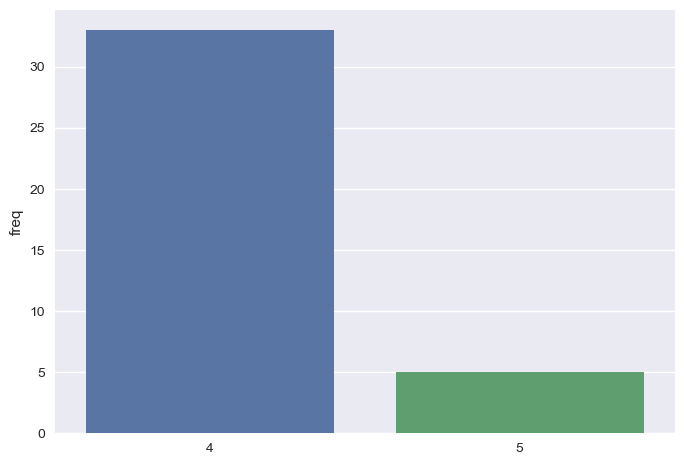

In [342]:
_ = coincident_stats(df.encoding)

coincident_rate: 15.25%
There are 108 encodings have more than 10 multiplicities, encoding 1566(3.0%) words.
extreme:


,freq
multiplicity,
11,28
12,19
13,14
14,9
15,9
19,8
16,6
17,4
20,3


quantile:


,multiplicity
quantile,
0.80,1.0
0.90,2.0
0.95,3.0
0.99,6.0


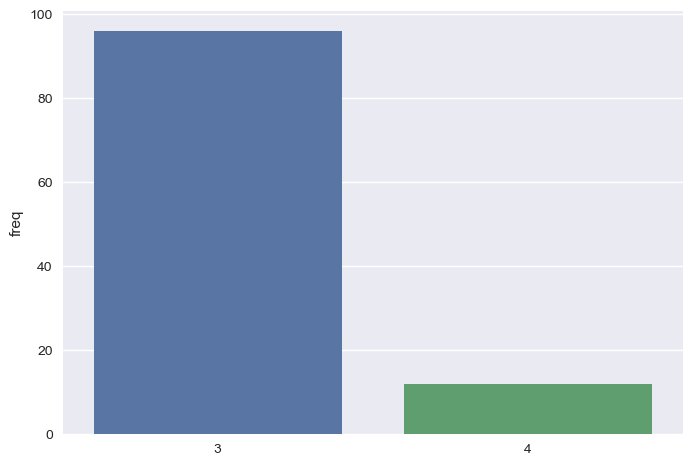

In [343]:
_ = coincident_stats(df.vowel_free)